## Compute my own drag coefficient from SAR data

To get the average Cd on a disk, wee need to compute the expression with integrals. Use cd_mean3 for new_dsg. For K25, the disk-average Cd is simply Cd0.

I computed a K based on V (cf Foster 2009), but this doesn't really change my distribution of C_K25 compared to when I just use the average K = 50 used for the fitting. 

NB: Unfortunately, when I use a reasonable scaling for K as a function of v, and inject it to compute C from C / sqrt(K), I get the correct dependance of Cd on Vmax, but a dependance of Cd on Rmax that is inversely that observed when considering Cd r v2 = cst. I think the filtering will not change anything. Note that using Cd r v2 = cst for the lower B values (i.e larger Rmax) will lead to higher Cd values in the inner-core, but is that really true? 

NB: Yet, when I use my C from Cd r v2 = cst to compute K from C / sqrt(K), I obtain a K that seems to scale with vmx^2. This is actually nice! How does it compare to the KPP scheme (Is this scheme the best one in Foster) and the measurements performed by Jun A Zhang and Zhao et al 2019 (BLM)? Do the same as for my Cd: use an arbitrary function of K as a function of v, and then integrate to estimate a constant K. My fitted model needs to be consistent with that. From the literature K increases (either linearly or quadratically) with v up to 40 m/s, and then keeps increasing or saturates (depending on the reference). K is rarely above 100 m2/s, and usually around 20-50.

Assumption: See Foster 2009: KPP model with h(r). K(z) is maximal (Km) at z = h/3, we thus assume that the average value of K over z is (h * Km)/3 / h, considering that h is the boundary layer height, and thus is Km / 3. For the radial dependance, we have Km ~ Ksfc ~ h(Rmax) ~ Vm^2. So the average K should really scale with Vm^2. So do not check that further.

When I estimate K either using my own Cd or a constant one, a few values exceed 1500 m2/s, but most of them are below 1500 m2/s. It's still one order of magnitude too high, but I don't want to remove these cases as they correspond to situations when the fit is really good.

Can I estimate (C /sqrt(K), c1, c2) from (Ut, VWS, Holland params)? Do I need to impose constraints on c1 or c2 first (e.g impose c2 > 0 during the fit)? 

In [3]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
from scipy.optimize import minimize

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [4]:
# Paths & Params
PTHS = {
    'dsg_pth': '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sar_dir': '/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/',
    'sav_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_GET_OWN_C/',
}

PRMS = {
    'sav_fgs': False,
}

# Open data
dsg = xr.open_dataset(PTHS['dsg_pth'])

In [5]:
# FILTERS
cond = (
    (dsg.center_quality_flag < 2) & 
    (dsg.percent_outside < 50) & 
    (dsg.percent_rmx_inside == 1) &
    (abs(dsg.lat) < 30) & 
    (dsg.rmx < 100000) & 
    (dsg.vmx > 20)
)
dsg_filtered    = dsg.where(cond, drop=True)
print(len(dsg_filtered.time))

640


In [6]:
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

### 1) Compute Cd from all SAR data

In [7]:
### Hyperparameters
rs = np.linspace(1000, 5e5, 500)

In [8]:
# Prepare new_dsg
listOfDatasets  = []

for t in tqdm(range(len(dsg_filtered.time))):
    # Open
    ds  = dsg_filtered.isel(time=t)

    # Determined parameters
    vmx = float(ds.vmx_hol)
    rmx = float(ds.rmx_hol)
    vmn = float(ds.vmn_hol)
    B   = float(ds.B_hol)
    lat = float(ds.lat)
    fcr = abs(float(ds.fcor))
    Ut  = float(ds.speed)
    
    # Holland
    V    = holland_profile(rs, lat, B, vmn, rmx, vmx)

    # Get own Cd
    cd             = np.ones_like(V) * 1e-3

    try:
        # For r > R+
        cd[V <= 10.92] = 1.2e-3 # We use 10.92 instead of 11 to ensure continuity of Cd
        outer          = (V > 10.92) & (rs >= float(ds.rps))
        cd[outer]      = (0.49 + 0.065 * V[outer]) * 1e-3
        # For Rmax < r < R+
        cdps           = cd[rs >= float(ds.rps)][0]
        near           = (rs <= float(ds.rps)) & (rs >= float(ds.rmx))
        cd[near]       = cdps * rs[rs >= float(ds.rps)][0] * V[rs >= float(ds.rps)][0] ** 2 / (rs[near] * V[near] ** 2)

        # Average
        cd_mean1   = cd[(rs >= float(ds.rmx)) & (rs <= float(ds.r0))].mean()
        
        rmax_to_r0 = (rs >= float(ds.rmx)) & (rs <= float(ds.r0))
        # Radial integral
        cd_mean2   = np.trapz(cd[rmax_to_r0], rs[rmax_to_r0]) / float(ds.r0 - ds.rmx)
        # Cylindrical integral
        cd_mean3   = 2 * np.trapz(cd[rmax_to_r0] * rs[rmax_to_r0], rs[rmax_to_r0]) / (float(ds.r0 - ds.rmx) ** 2)

        # K
        K_mean3    = 2 * np.trapz((V[rmax_to_r0] ** 2) * rs[rmax_to_r0], rs[rmax_to_r0]) / (float(ds.r0 - ds.rmx) ** 2)

        if PRMS['sav_fgs']:
            plt.plot(rs / 1000, cd * 1e3)
            plt.axvline(ds.rmx / 1000, c='k', linewidth=3)
            plt.axvline(ds.rps / 1000, c='k')
            plt.axvline(ds.r0  / 1000, c='k', linestyle='dashed')
            plt.xlim(0, 250)
            plt.xlabel(r'Distance from TC center (km)')
            plt.ylabel('Average Cd (x1e-3)')
            plt.grid()
    
            # Save
            plt.savefig(PTHS['sav_dir'] + 'figs/{}.png'.format(ds.file_tcva.item()[:-17]), bbox_inches='tight', format='png');plt.clf()
        
    except IndexError:
        cd_mean1 = cd_mean2 = cd_mean3 = np.nan
    
    # Append
    ds['cd_mean1'] = cd_mean1
    ds['cd_mean2'] = cd_mean2
    ds['cd_mean3'] = cd_mean3
    ds['K_mean3']  = K_mean3
    listOfDatasets.append(ds)

# Concatenate
print('Concatenating all datasets into ds_glob. Can take a few seconds...')
new_dsg = xr.concat(listOfDatasets, dim='time') # Concatenate all datasets into a global dataset
print('Concatenation ended.')

  0%|          | 0/640 [00:00<?, ?it/s]

/tmp/ipykernel_15659/2026389649.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  cd_mean2   = np.trapz(cd[rmax_to_r0], rs[rmax_to_r0]) / float(ds.r0 - ds.rmx)
/tmp/ipykernel_15659/2026389649.py:40: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  cd_mean3   = 2 * np.trapz(cd[rmax_to_r0] * rs[rmax_to_r0], rs[rmax_to_r0]) / (float(ds.r0 - ds.rmx) ** 2)
/tmp/ipykernel_15659/2026389649.py:43: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  K_mean3    = 2 * np.trapz((V[rmax_to_r0] ** 2) * rs[rmax_to_r0], rs[rmax_to_r0]) / (float(ds.r0 - ds.rmx) ** 2)


Concatenating all datasets into ds_glob. Can take a few seconds...
Concatenation ended.


Text(0, 0.5, 'Average Cd (x1e-3)')

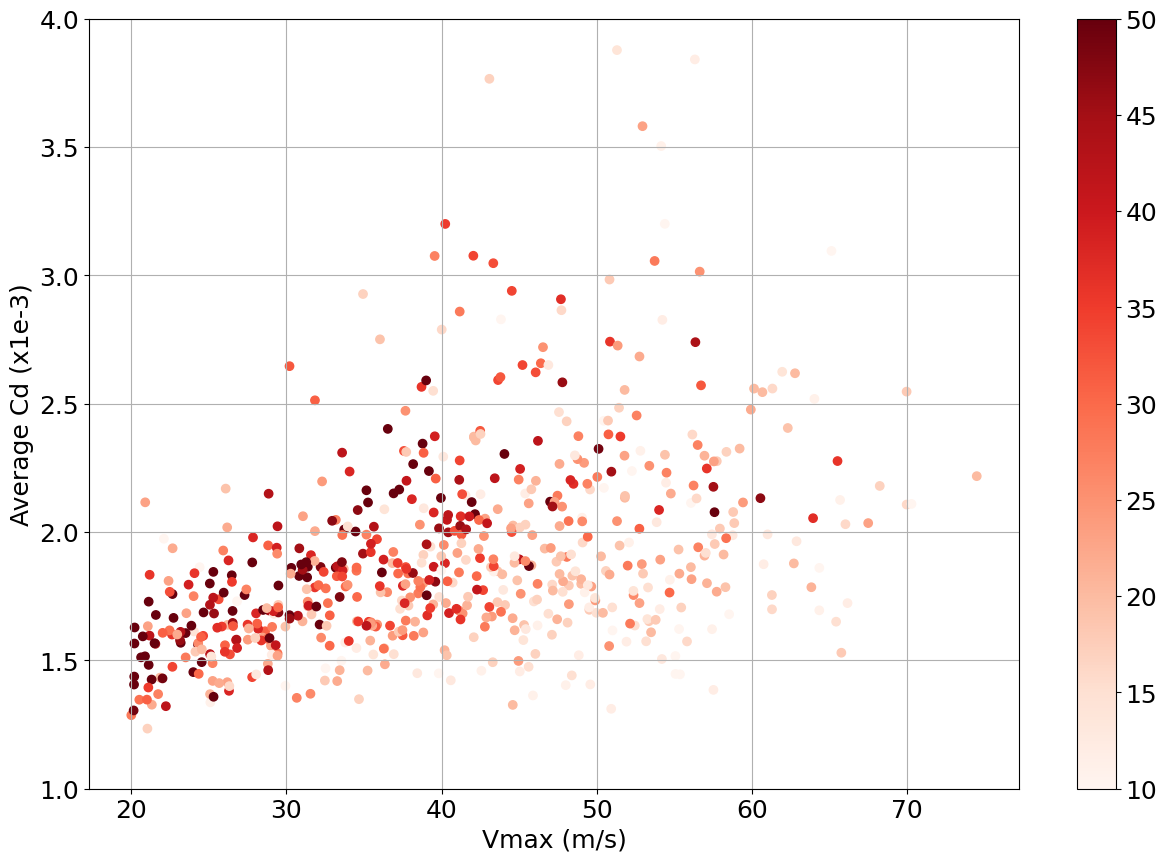

In [7]:
plt.scatter(new_dsg.vmx, new_dsg.cd_mean1 * 1e3, c=new_dsg.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar()
plt.ylim(1, 4)
plt.grid()
plt.xlabel('Vmax (m/s)')
plt.ylabel('Average Cd (x1e-3)')

In [8]:
# plt.scatter(new_dsg.cd_mean1, new_dsg.cd_mean2)
# plt.grid()
# plt.plot([0.001, 0.006], [0.001, 0.006])

Text(0, 0.5, 'Average Cd (x1e-3)')

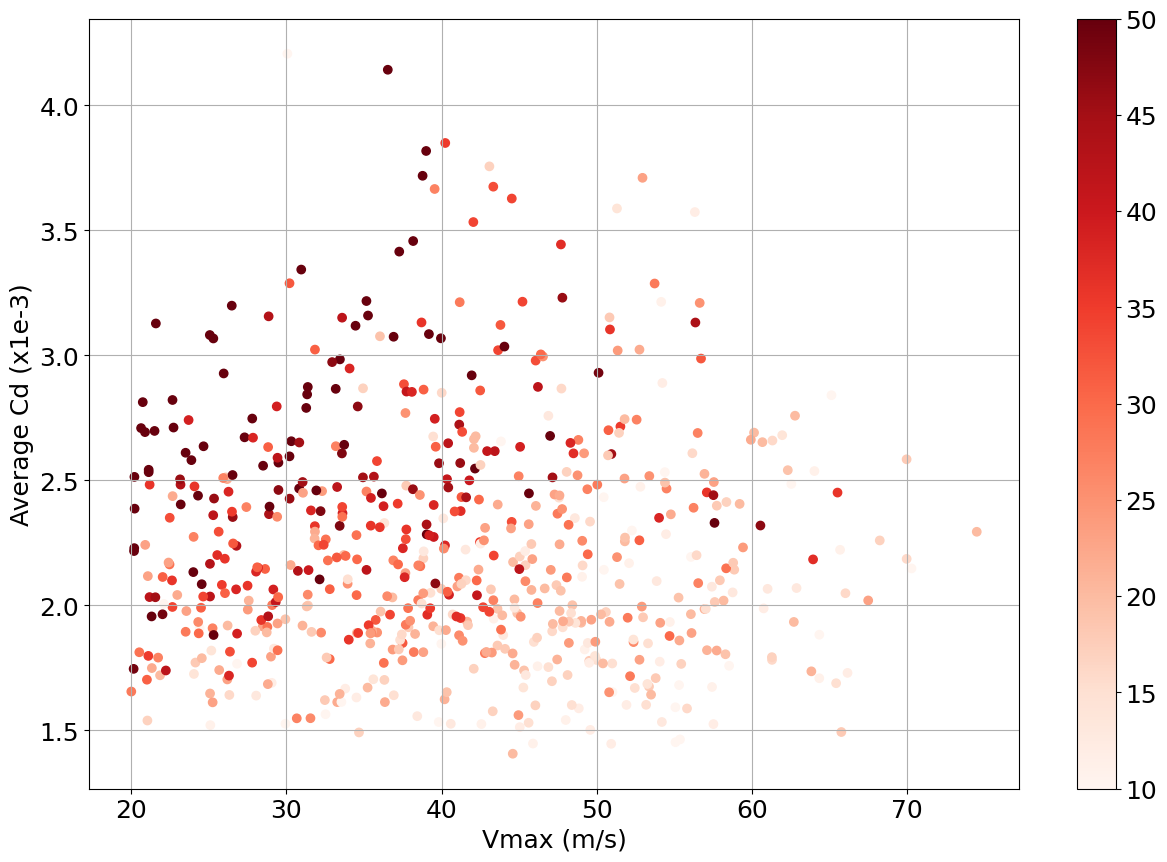

In [9]:
plt.scatter(new_dsg.vmx, new_dsg.cd_mean3 * 1e3, c=new_dsg.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar()
# plt.ylim(1, 4)
plt.grid()
plt.xlabel('Vmax (m/s)')
plt.ylabel('Average Cd (x1e-3)')

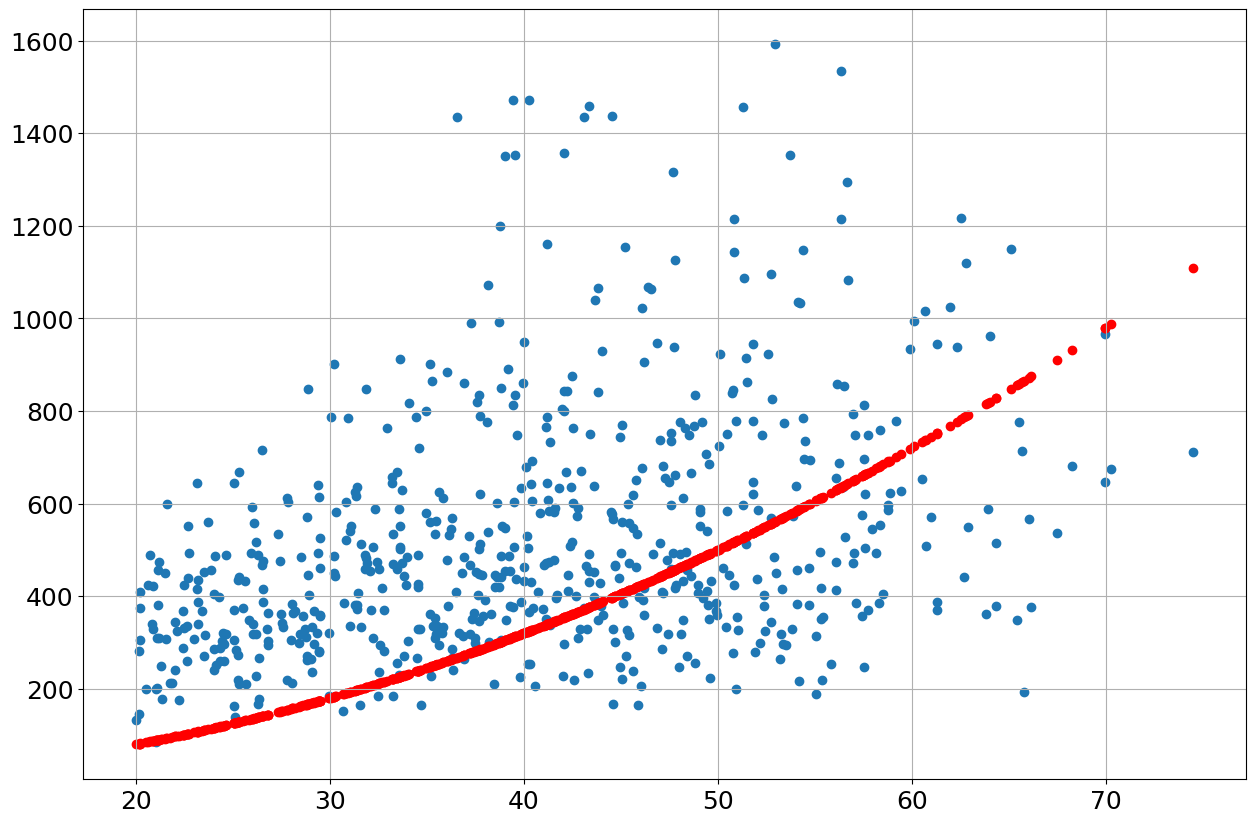

In [10]:
plt.scatter(new_dsg.vmx, new_dsg.K_mean3)
plt.scatter(new_dsg.vmx, new_dsg.vmx ** 2 / 5, color='r')
plt.grid()

In [11]:
# p  = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25/dsg_K25_withKsetto50.nc'
# dk = xr.open_dataset(p)
# dk.where(dk.C_sqrtK_K25 > 1.41e-3, drop=True).file_tcva

### 2) Compare with model data

TODO: Filter the higher C values? (for now I only filter out the lower ones)

In [9]:
p   = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25/dsg_K25_withKsetto50.nc'
dkg = xr.open_dataset(p)
dk = dkg.where(
    (dkg.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg.dist2coast  > dkg.r34)             & # Distance to coast
    (dkg.percent_outside < 10)              & # Sufficient SAR coverage
    (dkg.vmx > 33)                          & # Test
    (dkg.C_K25 != 0.0001)                   & # Reached the lower bound
    (dkg.asym_avg_err  <= 2.5)              & # Test
    (dkg.phase_avg_err <= 45)               & # Test
    # (dkg.C_sqrtK_K25 > 1.5e-5)              & # Reached the lower bound
    # (dkg.C_sqrtK_K25 < 1.41e-3)             & # Reached the upper bound
    (~xr.where(dkg.non_C1 == 0, False, True)) # Ensure that I > V/r
)
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
print(len(dkg.time))

640


In [64]:
# ### TODO: Remove
# dk['C_K25'] = dk.C_K25 / np.sqrt(50)

Text(0, 0.5, 'Average Cd (x1e-3)')

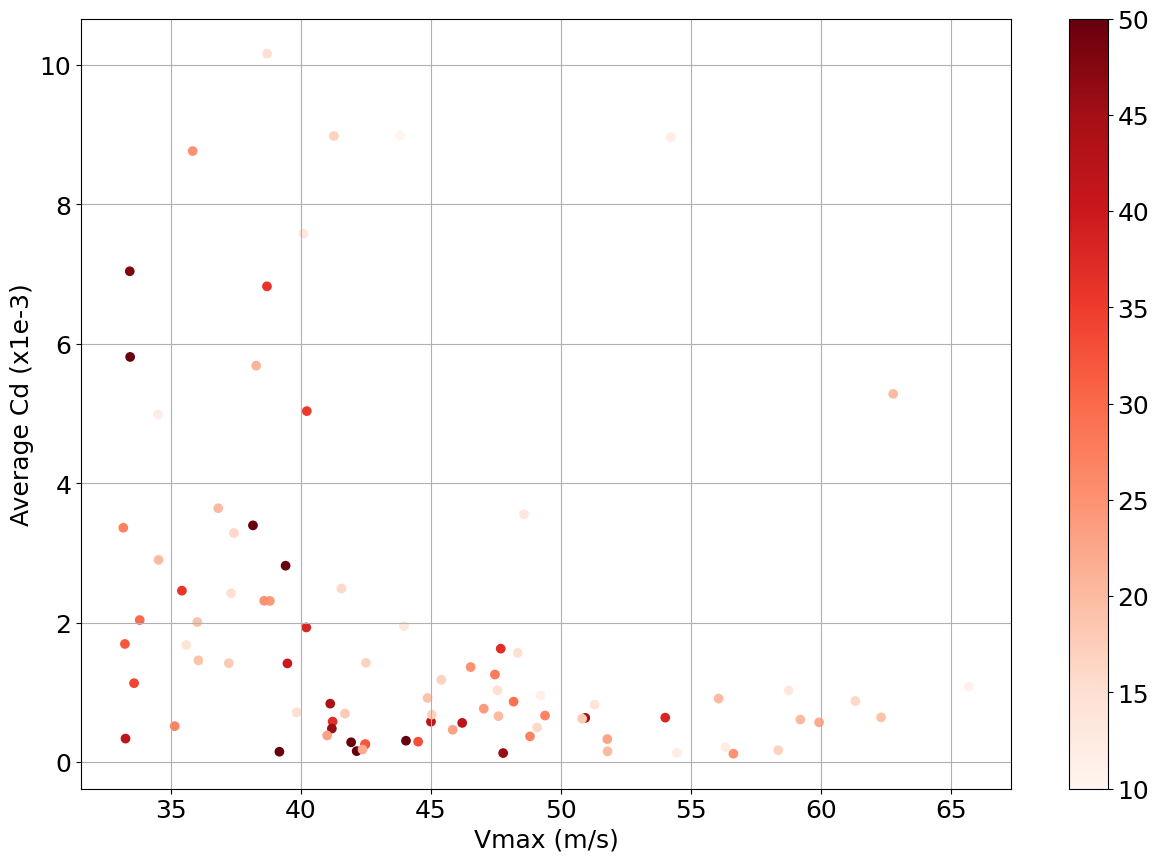

In [65]:
plt.scatter(dk.vmx, dk.C_K25 * 1e3, c=dk.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar()
# plt.ylim(1, 4)
plt.grid()
plt.xlabel('Vmax (m/s)')
plt.ylabel('Average Cd (x1e-3)')

Text(0, 0.5, 'Average Cd (x1e-3)')

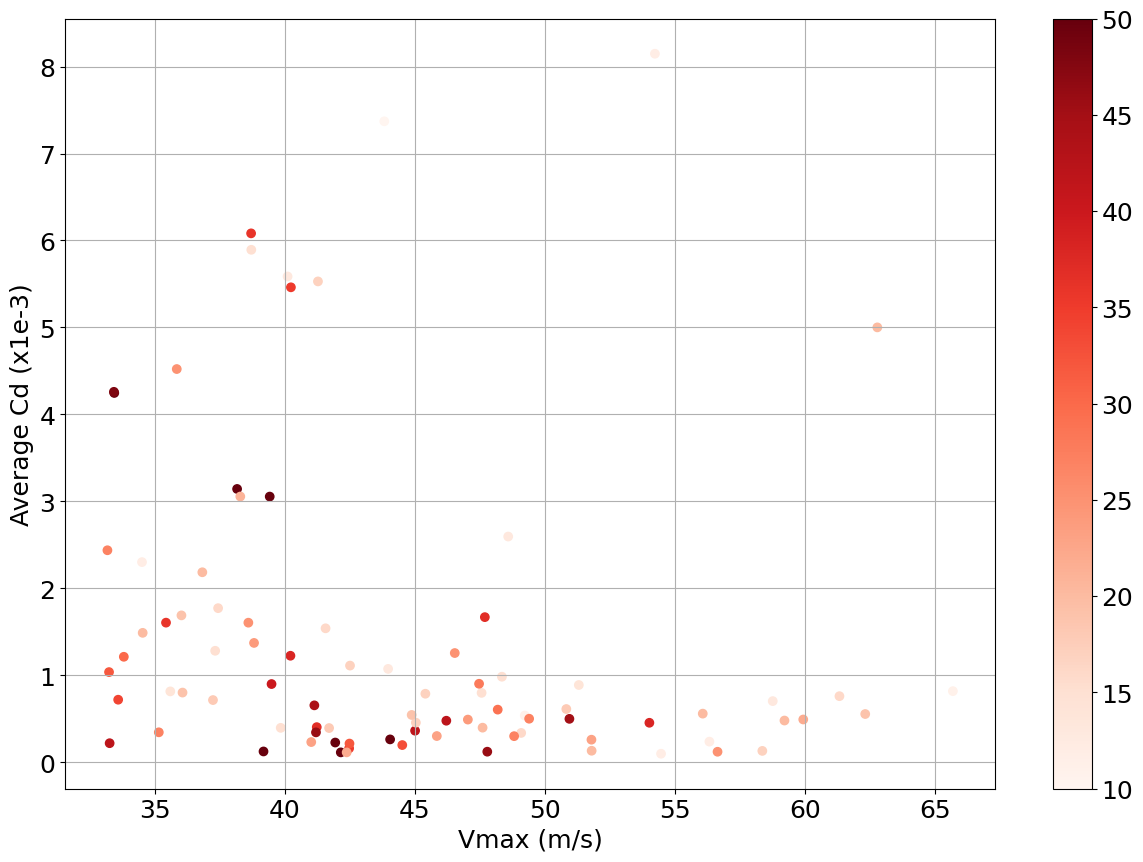

In [66]:
dsm = xr.merge([dk, new_dsg], join="inner")

plt.scatter(dsm.vmx, np.sqrt(dsm.K_mean3) / 5 * dsm.C_sqrtK_K25 * 1e3, c=dsm.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar()
# plt.ylim(1, 4)
plt.grid()
plt.xlabel('Vmax (m/s)')
plt.ylabel('Average Cd (x1e-3)')

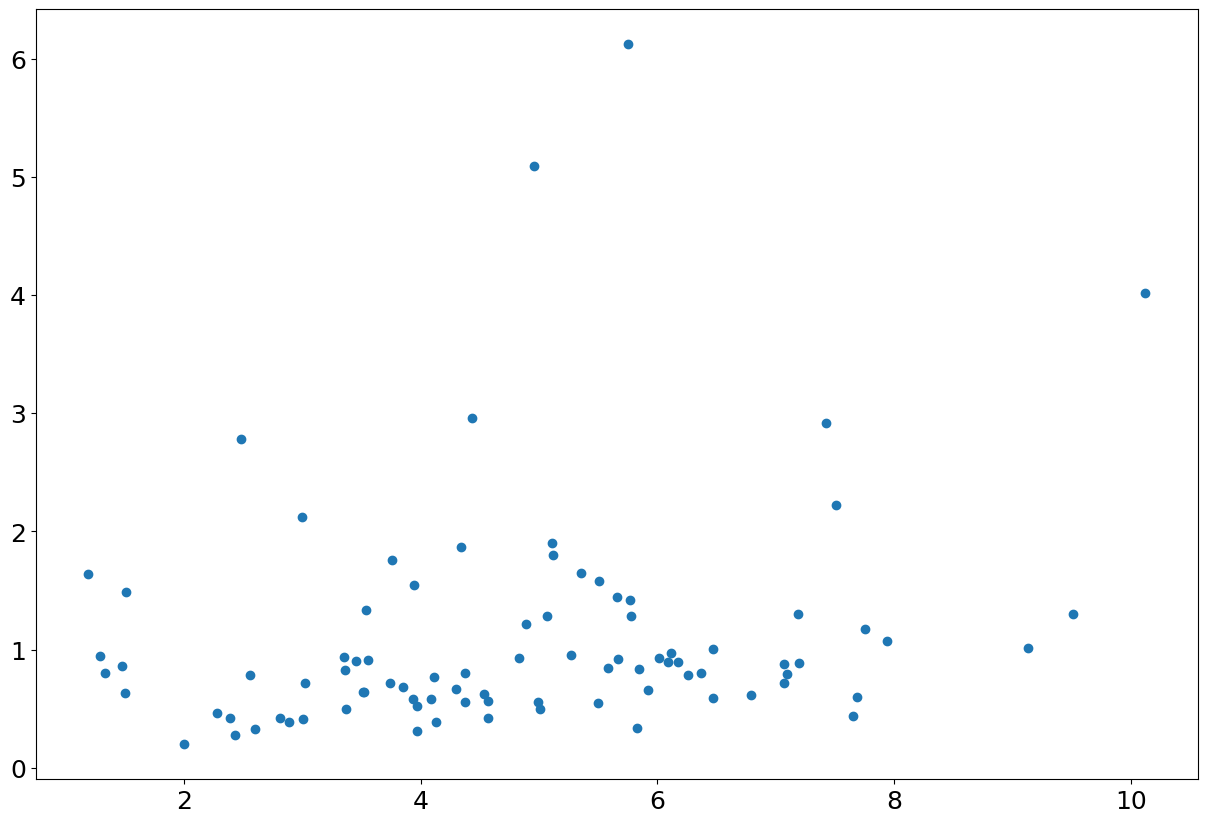

In [67]:
plt.scatter(dk.speed, np.sqrt(dk.c1_K25 ** 2 + dk.c2_K25 ** 2))

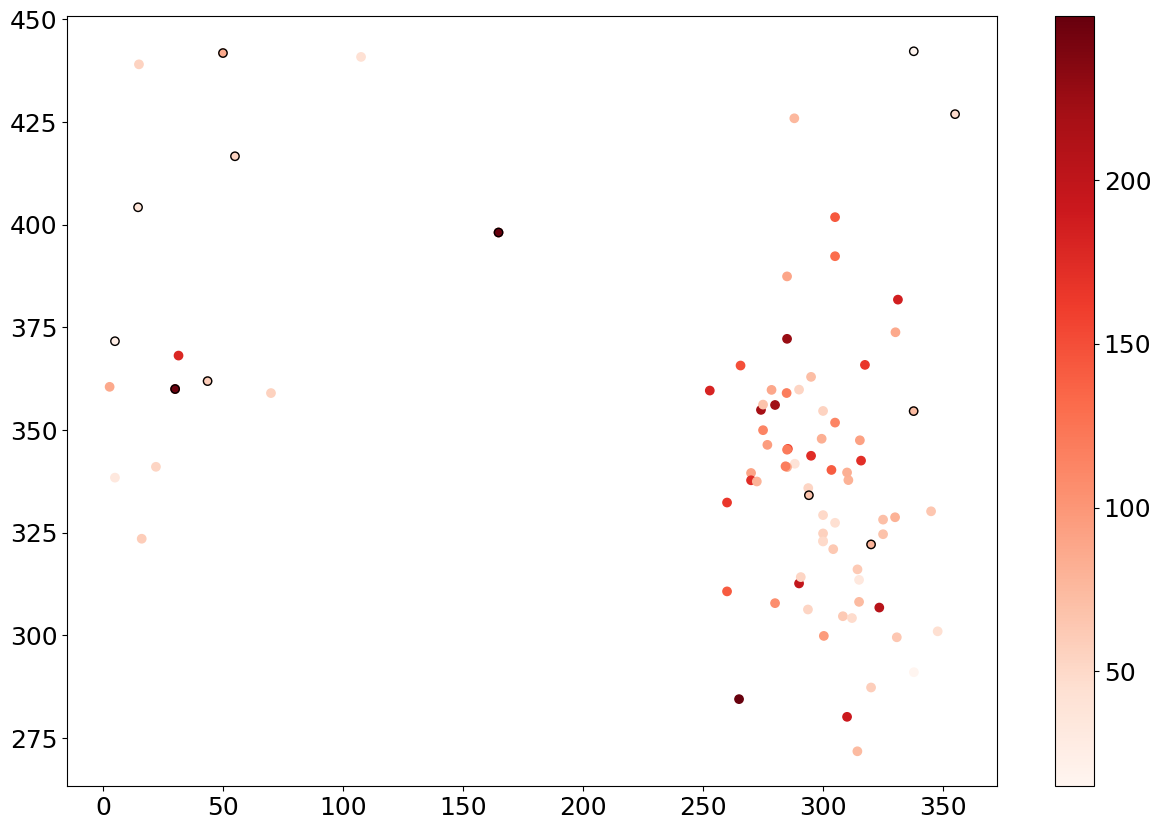

In [68]:
angles     = (np.rad2deg(np.arctan((dk.c1_K25 / dk.c2_K25))) % 360).copy(deep=True)
angles_bis = xr.where(angles >= 180, angles, angles + 360)
plt.scatter(dk.storm_dir_ibt, angles_bis, c=dk.wsd_pmd,                                                                      cmap=plt.get_cmap('Reds'))
plt.scatter(dk.storm_dir_ibt.where(dk.vws_pmd > 10), angles_bis.where(dk.vws_pmd > 10), c=dk.wsd_pmd.where(dk.vws_pmd > 10), cmap=plt.get_cmap('Reds'), edgecolors='k')
plt.colorbar()

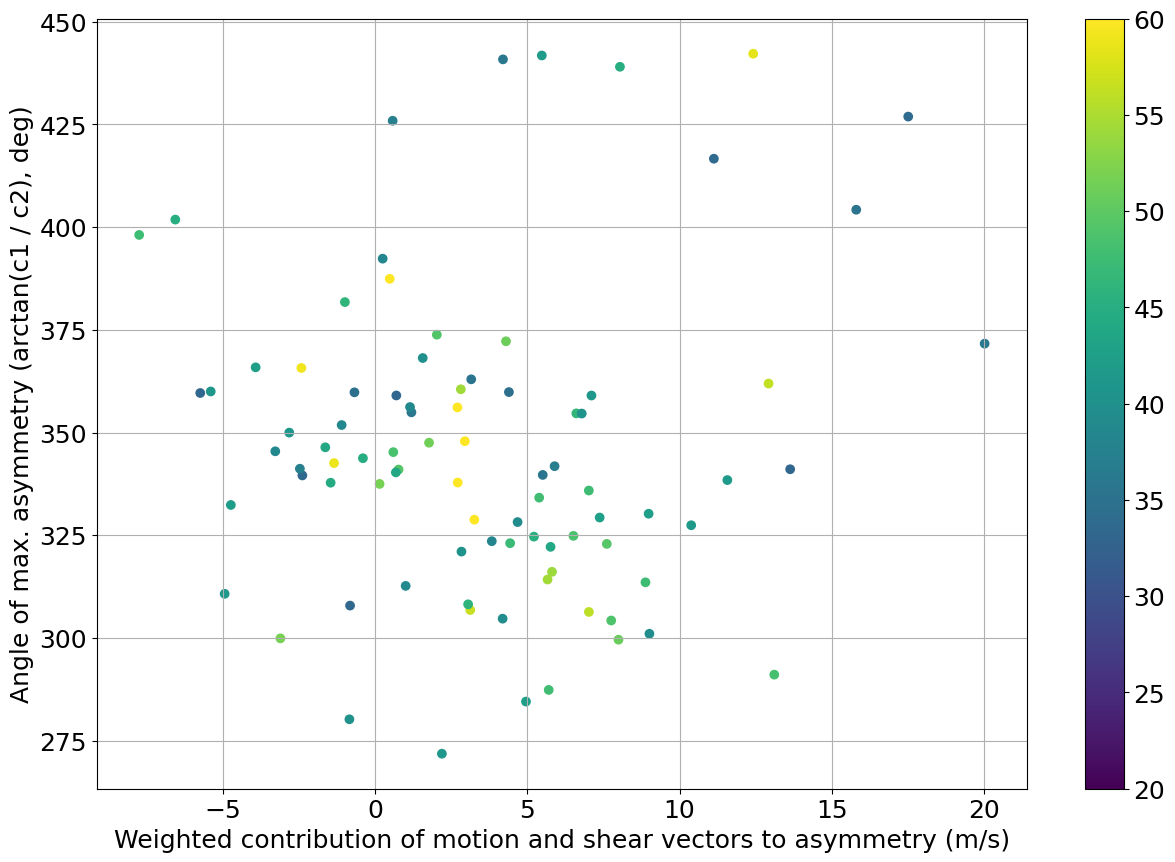

In [69]:
# c1 / c2 as a function of relative contribution from shear and motion vectors
# NB: les outliers en haut semblent normaux
# NB: l'outlier tout à gauche à un Vmax très faible, proche de 20 m/s
plt.scatter(dk.storm_speed_ibt * np.cos(np.deg2rad(dk.storm_dir_ibt)) + dk.vws_pmd * np.cos(np.deg2rad(dk.wsd_pmd)), angles_bis, c=dk.vmx, vmin=20, vmax=60)
plt.colorbar()
plt.xlabel('Weighted contribution of motion and shear vectors to asymmetry (m/s)')
plt.ylabel('Angle of max. asymmetry (arctan(c1 / c2), deg)')
plt.grid()

In [70]:
dk['wght_cont']  = dk.storm_speed_ibt * np.cos(np.deg2rad(dk.storm_dir_ibt)) + dk.vws_pmd * np.cos(np.deg2rad(dk.wsd_pmd))
dk['angles_bis'] = angles_bis

In [71]:
dk.where(dk.angles_bis > 425, drop=True).wght_cont

<xarray.DataArray 'wght_cont' (time: 6)> Size: 48B
array([17.51307812,  8.04310927,  5.4765906 ,  0.57665257, 12.41979242,
        4.20032835])
Coordinates:
  * time     (time) datetime64[ns] 48B 2018-09-01T03:24:42 ... 2024-10-07T00:...

In [72]:
dk.where(dk.angles_bis > 425, drop=True).file_tcva

<xarray.DataArray 'file_tcva' (time: 6)> Size: 48B
array(['s1b-ew-owi-ca-20180901t032311-20180901t032613-000003-01715C_sw_ep152018_cyclone_polar.nc',
       's1b-ew-owi-ca-20191106t194803-20191106t195007-000003-02377F_sw_wp242019_cyclone_polar.nc',
       'rcm2-sc50md-owi-ca-20210422t211644-20210422t212548-00003-______sw_wp022021_cyclone_polar.nc',
       'rcm3-sc50mc-owi-ca-20231007t221032-20231007t221115-00003-______sw_wp142023_cyclone_polar.nc',
       'rcm2-sc50mc-owi-ca-20231019t130413-20231019t130530-00003-______sw_ep172023_cyclone_polar.nc',
       'rcm2-sclnd-owi-ca-20241007t002203-20241007t002321-00003-______sw_al142024_cyclone_polar.nc'],
      dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 48B 2018-09-01T03:24:42 ... 2024-10-07T00:...
Attributes:
    long_name:    File name in the TCVA database
    description:  Taken from Ifremer TCVA product

In [73]:
dk.where(dk.wght_cont < -20, drop=True).file_tcva

<xarray.DataArray 'file_tcva' (time: 0)> Size: 0B
array([], dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 0B 
Attributes:
    long_name:    File name in the TCVA database
    description:  Taken from Ifremer TCVA product

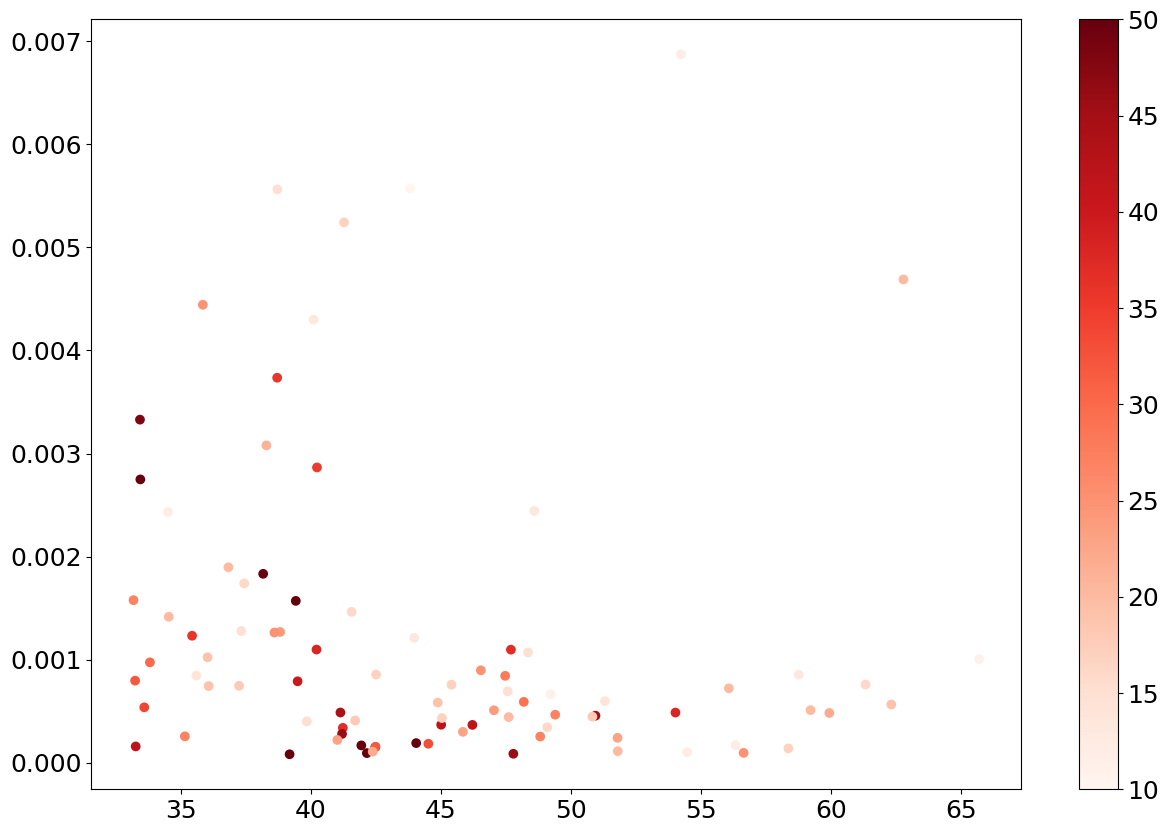

In [23]:
plt.scatter(dk.vmx, dk.C_sqrtK_K25 * dk.vmx / 10, c=dk.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar()

(0.0014, 0.0015)

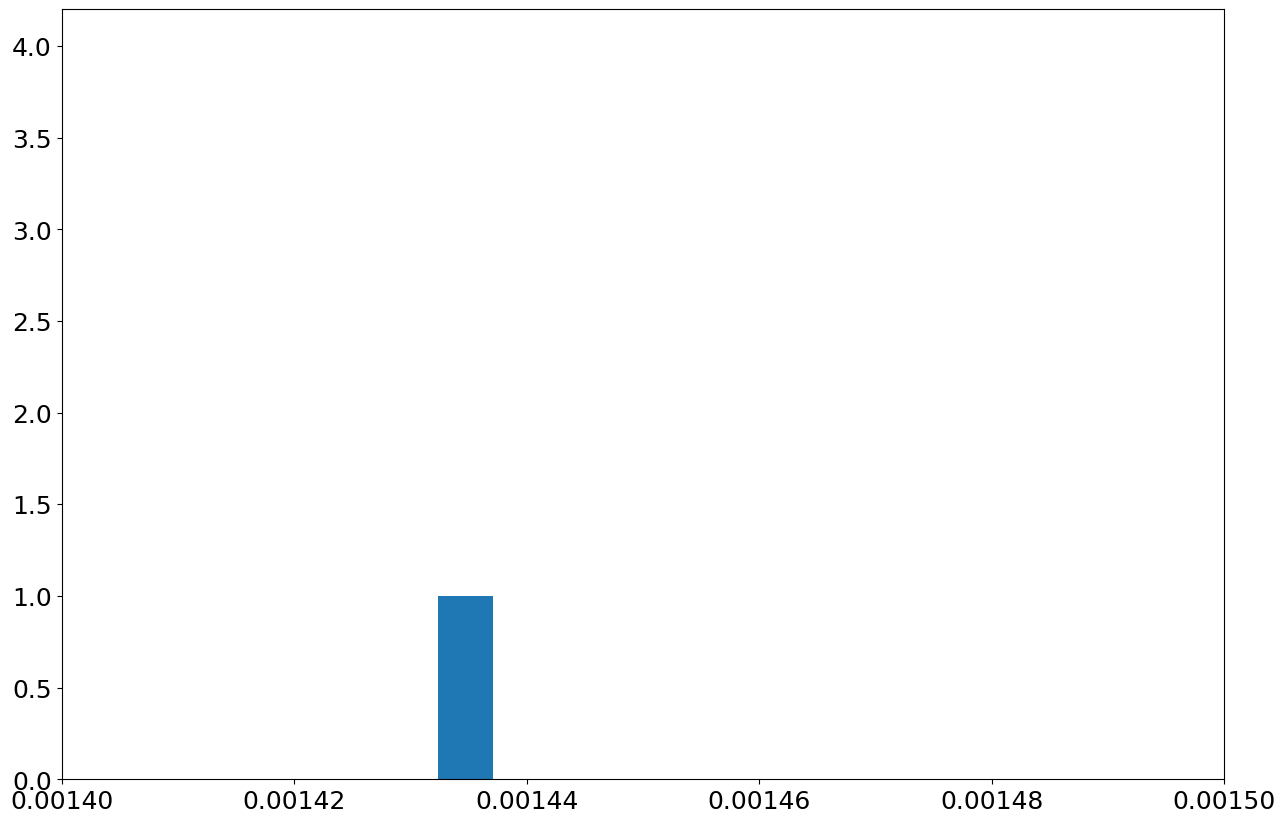

In [24]:
plt.hist(dk.C_sqrtK_K25, bins=300)
plt.xlim(0.0014, 0.0015)

In [25]:
dk.where(dk.C_sqrtK_K25 > 1.41e-3, drop=True).file_tcva

<xarray.DataArray 'file_tcva' (time: 1)> Size: 8B
array(['rcm1-sc50ma-owi-ca-20240803t014918-20240803t015035-00003-______sw_ep032024_cyclone_polar.nc'],
      dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 8B 2024-08-03T01:49:56
Attributes:
    long_name:    File name in the TCVA database
    description:  Taken from Ifremer TCVA product

In [26]:
dk.where(dk.C_sqrtK_K25 < 1.5e-5, drop=True).C_sqrtK_K25

<xarray.DataArray 'C_sqrtK_K25' (time: 0)> Size: 0B
array([], dtype=float64)
Coordinates:
  * time     (time) datetime64[ns] 0B

(0.0, 0.002)

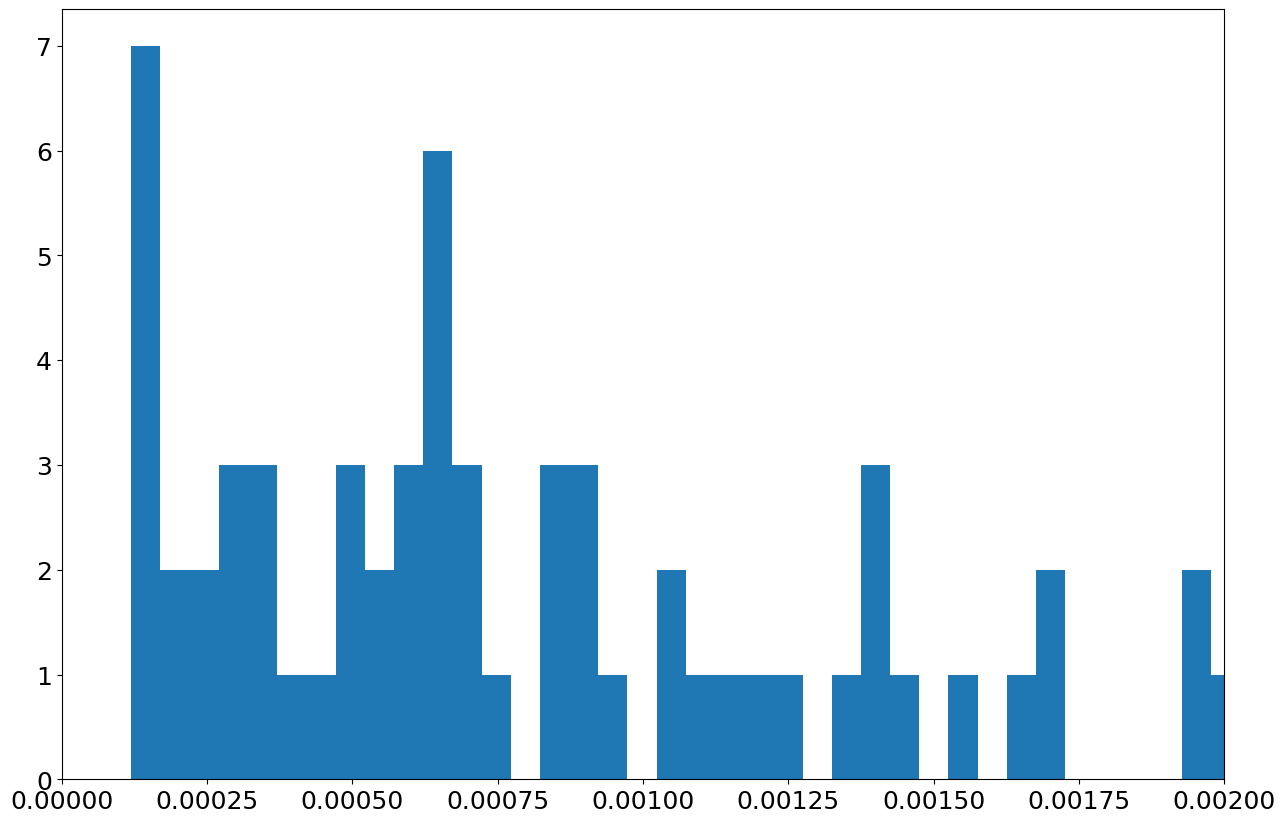

In [27]:
plt.hist(dk.C_K25, bins=200)
plt.xlim(0, 0.002)

In [28]:
dk.where(dk.C_K25 < 0.000708, drop=True).file_tcva

<xarray.DataArray 'file_tcva' (time: 35)> Size: 280B
array(['rs2--owi-ca-20140717t102721-20140717t102909-00003-______sw_wp092014_cyclone_polar.nc',
       'rs2--owi-ca-20141101t205327-20141101t205443-00003-______sw_wp202014_cyclone_polar.nc',
       'rs2--owi-ca-20150516t203538-20150516t203654-00003-______sw_wp072015_cyclone_polar.nc',
       's1a-ew-owi-ca-20180831t203802-20180831t204009-000003-028EDA_sw_wp252018_cyclone_polar.nc',
       's1b-ew-owi-ca-20180911t204751-20180911t204937-000003-017624_sw_wp262018_cyclone_polar.nc',
       'rs2--owi-ca-20180912t091024-20180912t091140-00003-______sw_wp262018_cyclone_polar.nc',
       's1a-ew-owi-ca-20181003t134006-20181003t134210-000003-029E52_sw_ep212018_cyclone_polar.nc',
       's1a-ew-owi-ca-20181006t140456-20181006t140700-000003-029FBE_sw_ep212018_cyclone_polar.nc',
       's1a-ew-owi-ca-20181007t023405-20181007t023610-000003-029FF5_sw_ep212018_cyclone_polar.nc',
       's1a-ew-owi-ca-20181025t203134-20181025t203308-000003-02A8D5_sw_wp312018_cyclone_polar.nc',
       's1b-ew-owi-ca-20190614t133247-20190614t133442-000003-01F6A9_sw_io022019_cyclone_polar.nc',
       's1a-ew-owi-ca-20191008t203040-20191008t203250-000003-0356ED_sw_wp202019_cyclone_polar.nc',
       's1b-ew-owi-ca-20191106t194803-20191106t195007-000003-02377F_sw_wp242019_cyclone_polar.nc',
       'rs2--owi-ca-20201003t141913-20201003t142136-00003-______sw_ep182020_cyclone_polar.nc',
       'rcm2-sc50md-owi-ca-20210422t211644-20210422t212548-00003-______sw_wp022021_cyclone_polar.nc',
       'rs2--owi-ca-20210907t092755-20210907t093019-00003-______sw_al122021_cyclone_polar.nc',
       's1b-ew-owi-ca-20210907t214630-20210907t215005-000003-0369AB_sw_al122021_cyclone_polar.nc',
       's1a-ew-owi-ca-20210925t204659-20210925t204934-000003-04B69E_sw_wp202021_cyclone_polar.nc',
       'rcm1-sc50mc-owi-ca-20230614t012242-20230614t012349-00003-______sw_io022023_cyclone_polar.nc',
       'rcm3-sc50ma-owi-ca-20230714t020421-20230714t020538-00003-______sw_ep032023_cyclone_polar.nc',
       'rcm1-sc50mb-owi-ca-20230819t132648-20230819t132805-00003-______sw_ep092023_cyclone_polar.nc',
       's1a-ew-owi-ca-20230908t092521-20230908t092624-000003-060BF1_sw_al132023_cyclone_polar.nc',
       'rcm1-sclnb-owi-ca-20230910t095738-20230910t095854-00003-______sw_al132023_cyclone_polar.nc',
       'rcm1-sclnb-owi-ca-20230910t221257-20230910t221412-00003-______sw_al132023_cyclone_polar.nc',
       'rcm1-sclnb-owi-ca-20230911t204541-20230911t204657-00003-______sw_al142023_cyclone_polar.nc',
       'rcm1-sclnc-owi-ca-20230912t101305-20230912t101421-00003-______sw_al132023_cyclone_polar.nc',
       'rcm3-sc50mb-owi-ca-20231003t094502-20231003t094617-00003-______sw_wp142023_cyclone_polar.nc',
       'rcm2-sclnd-owi-ca-20231012t200843-20231012t201000-00003-______sw_wp152023_cyclone_polar.nc',
       'rcm2-sc50mc-owi-ca-20231019t130413-20231019t130530-00003-______sw_ep172023_cyclone_polar.nc',
       'rcm2-sc50md-owi-ca-20240823t141611-20240823t141729-00003-______sw_ep072024_cyclone_polar.nc',
       'rcm2-sc50mc-owi-ca-20240904t102430-20240904t102548-00003-______sw_wp122024_cyclone_polar.nc',
       'rcm2-sc50mc-owi-ca-20240905t103247-20240905t103359-00003-______sw_wp122024_cyclone_polar.nc',
       'rcm1-sclnc-owi-ca-20241004t212518-20241004t212636-00003-______sw_al122024_cyclone_polar.nc',
       's1a-ew-owi-ca-20241025t021734-20241025t021838-000003-06E34A_sw_ep122024_cyclone_polar.nc',
       's1a-ew-owi-ca-20241104t212136-20241104t212239-000003-06E988_sw_wp242024_cyclone_polar.nc'],
      dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 280B 2014-07-17T10:28:15 ... 2024-11-04T21...
Attributes:
    long_name:    File name in the TCVA database
    description:  Taken from Ifremer TCVA product

### Backing up K assuming that C is known from Cd r v2 = cst

In [86]:
own_K  = (1 / (dsm.C_sqrtK_K25 / (1 * dsm.cd_mean3))) ** 2 # with Cd r v^2 = cst
own_K2 = (1 / (dsm.C_sqrtK_K25 / 2e-3)) ** 2               # with Cd = 2e-3

(0.0, 1000.0)

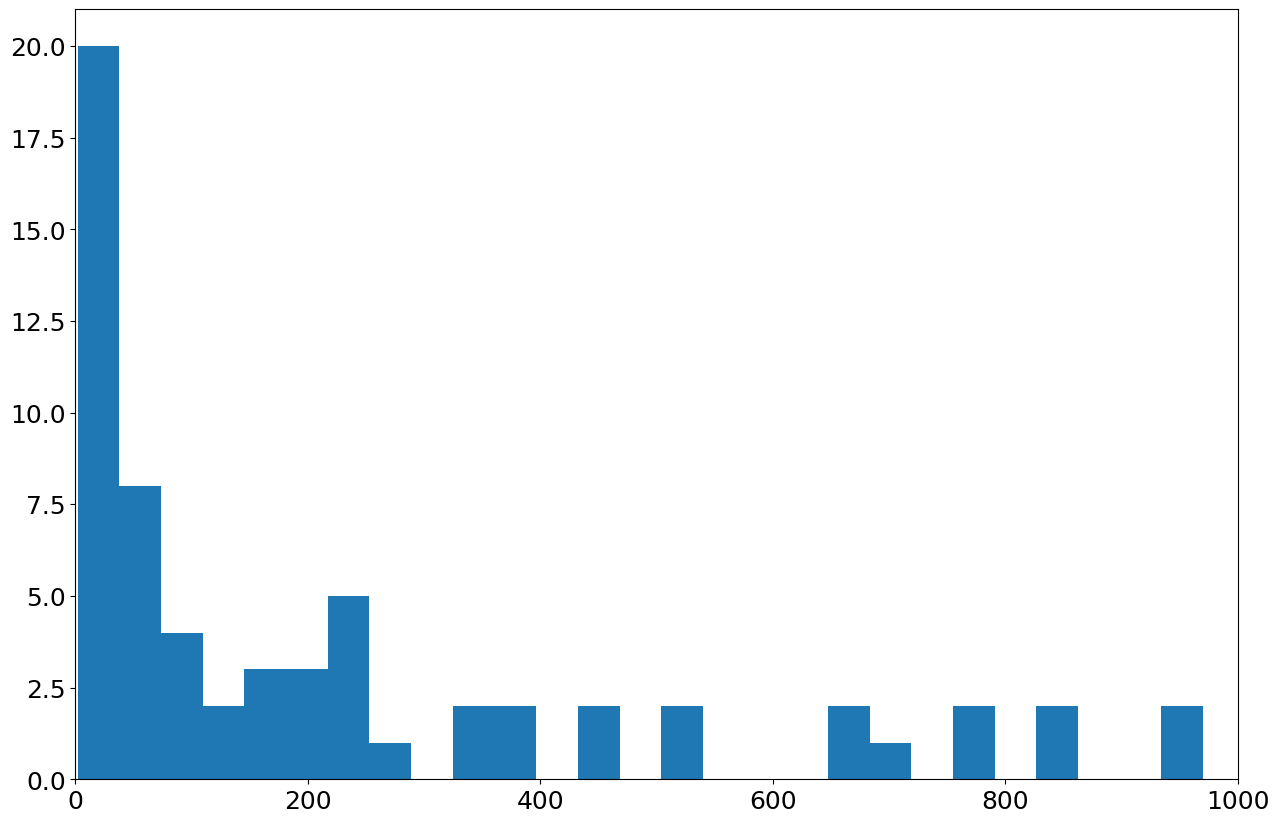

In [30]:
plt.hist(own_K, bins=1000)
plt.xlim(0, 1000)

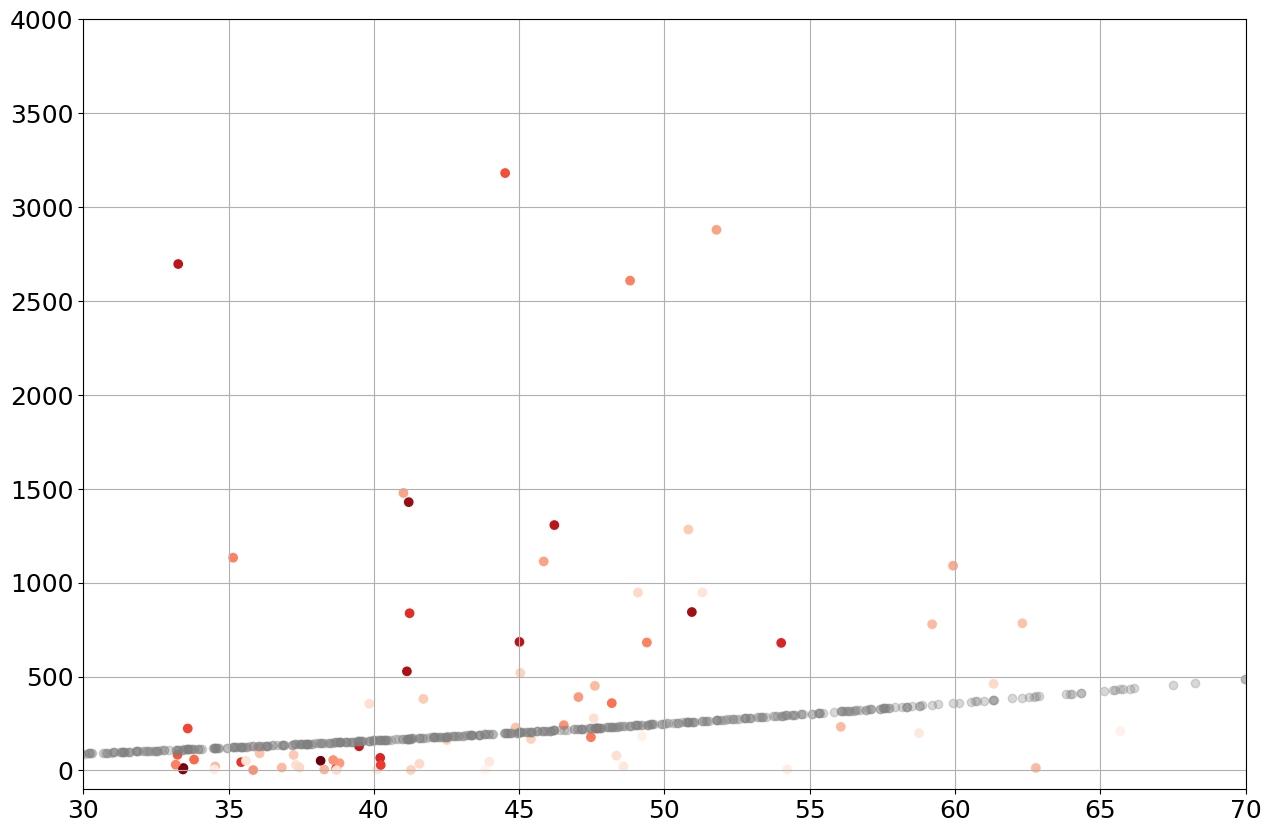

In [90]:
plt.scatter(dsm.vmx, own_K, c=dsm.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.scatter(dsm.vmx, 0.1 * dsm.vmx ** 2, c='gray', alpha=0.3)
# plt.ylim(-10, 800)
plt.ylim(-100, 4000)
plt.xlim(30, 70)
plt.grid()

In [75]:
dsm.where(own_K > 10000, drop=True).file_tcva

<xarray.DataArray 'file_tcva' (time: 8)> Size: 64B
array(['s1a-ew-owi-ca-20181007t023405-20181007t023610-000003-029FF5_sw_ep212018_cyclone_polar.nc',
       's1a-ew-owi-ca-20191008t203040-20191008t203250-000003-0356ED_sw_wp202019_cyclone_polar.nc',
       's1b-ew-owi-ca-20210907t214630-20210907t215005-000003-0369AB_sw_al122021_cyclone_polar.nc',
       's1a-ew-owi-ca-20230908t092521-20230908t092624-000003-060BF1_sw_al132023_cyclone_polar.nc',
       'rcm1-sclnc-owi-ca-20230912t101305-20230912t101421-00003-______sw_al132023_cyclone_polar.nc',
       'rcm2-sclnd-owi-ca-20231012t200843-20231012t201000-00003-______sw_wp152023_cyclone_polar.nc',
       'rcm2-sc50mc-owi-ca-20231019t130413-20231019t130530-00003-______sw_ep172023_cyclone_polar.nc',
       'rcm2-sc50mc-owi-ca-20240905t103247-20240905t103359-00003-______sw_wp122024_cyclone_polar.nc'],
      dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 64B 2018-10-07T02:35:07 ... 2024-09-05T10:...
Attributes:
    long_name:    File name in the TCVA database
    description:  Taken from Ifremer TCVA product

In [77]:
dsm.where(own_K > 10000, drop=True).max_asym_sar

<xarray.DataArray 'max_asym_sar' (time: 8)> Size: 64B
array([3.84383733, 2.37553657, 4.4756809 , 7.06944226, 3.59590783,
       8.6839723 , 5.52656552, 7.31371192])
Coordinates:
  * time     (time) datetime64[ns] 64B 2018-10-07T02:35:07 ... 2024-09-05T10:...

In [82]:
dsm.where(own_K > 10000, drop=True).cd_mean3 * 1e3

<xarray.DataArray 'cd_mean3' (time: 8)> Size: 64B
array([2.54703535, 3.20985728, 3.08514761, 2.28461629, 3.23070695,
       3.5733827 , 2.41319865, 2.74486127])
Coordinates:
  * time     (time) datetime64[ns] 64B 2018-10-07T02:35:07 ... 2024-09-05T10:...

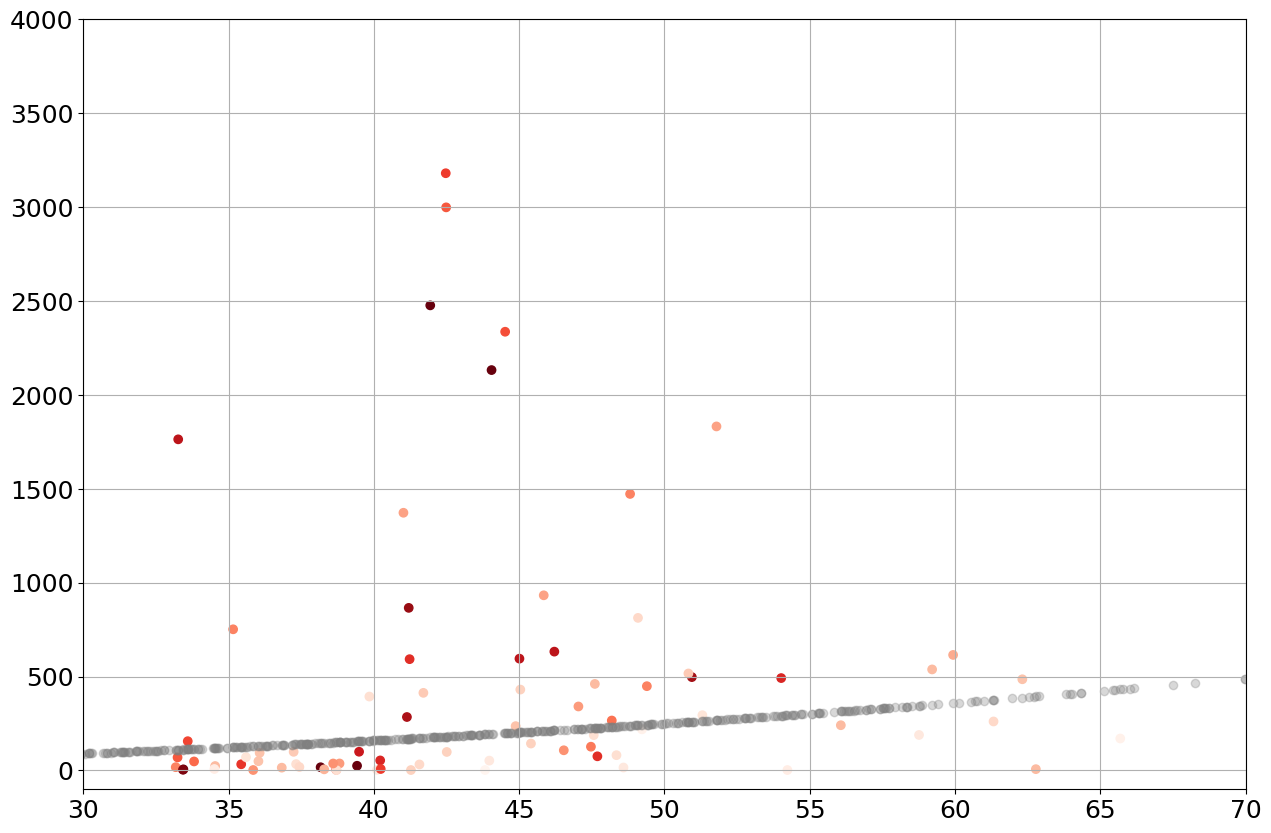

In [101]:
plt.scatter(dsm.vmx, own_K2, c=dsm.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.scatter(dsm.vmx, 0.1 * dsm.vmx ** 2, c='gray', alpha=0.3)
plt.ylim(-100, 4000)
plt.xlim(30, 70)
plt.grid()

### Grouping cases that have a similar Vmax, B, and Rmax

In [98]:
dkk = dk.where(
    (dk.vmx >= 40) & (dk.vmx <= 50) & (dk.B_hol >= 1.5) & (dk.B_hol <= 2) & (dk. rmx <= 30000)
)

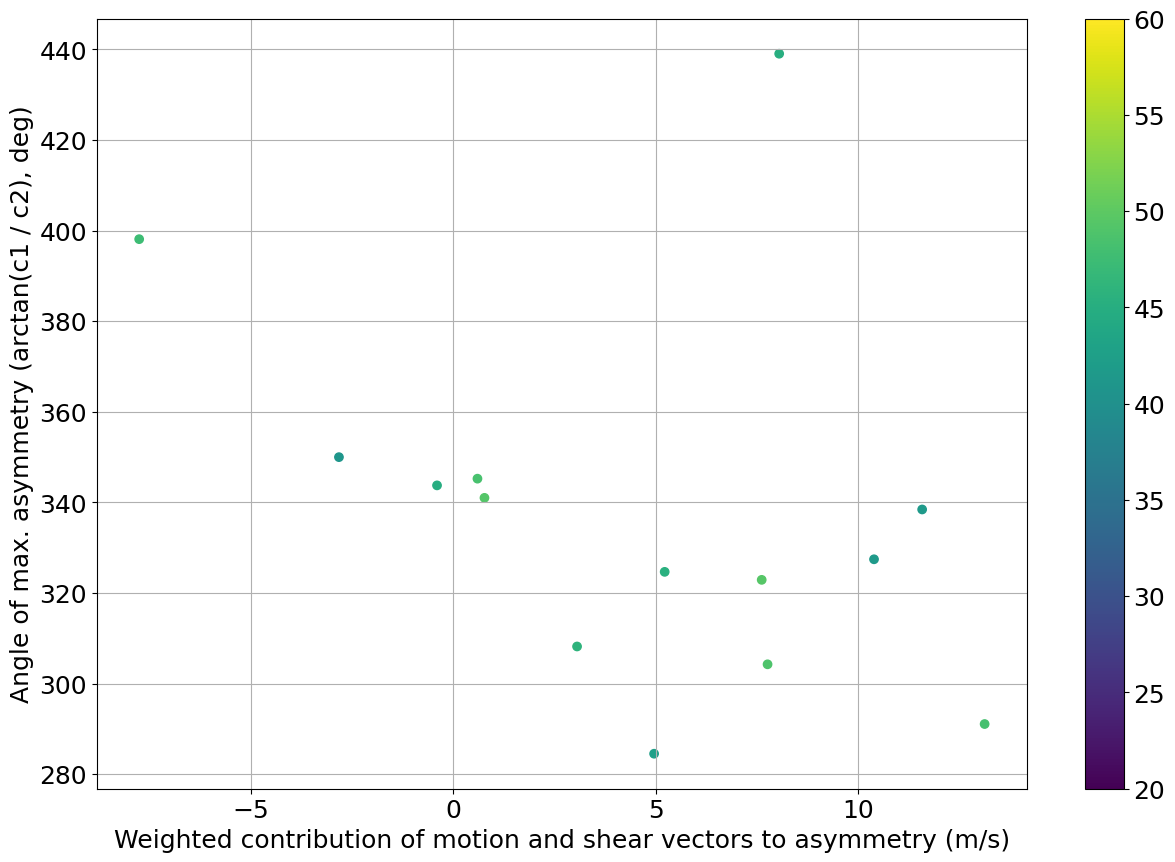

In [99]:
# c1 / c2 as a function of relative contribution from shear and motion vectors
# NB: les outliers en haut semblent normaux
# NB: l'outlier tout à gauche à un Vmax très faible, proche de 20 m/s
plt.scatter(dkk.storm_speed_ibt * np.cos(np.deg2rad(dkk.storm_dir_ibt)) + dkk.vws_pmd * np.cos(np.deg2rad(dkk.wsd_pmd)), angles_bis, c=dkk.vmx, vmin=20, vmax=60)
plt.colorbar()
plt.xlabel('Weighted contribution of motion and shear vectors to asymmetry (m/s)')
plt.ylabel('Angle of max. asymmetry (arctan(c1 / c2), deg)')
plt.grid()

### Estimating (C /sqrt(K), c1, c2) from (Ut, VWS, Holland params)

CAVEAT: I need to consider the cosinus/sinus of the angles.

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [12]:
dk['cos_mtnd'] = np.cos(np.deg2rad(dk.storm_dir_ibt))
dk['sin_mtnd'] = np.sin(np.deg2rad(dk.storm_dir_ibt))
dk['cos_vwsd'] = np.cos(np.deg2rad(dk.wsd_pmd))
dk['sin_vwsd'] = np.sin(np.deg2rad(dk.wsd_pmd))

In [39]:
preds   = ['storm_speed_ibt', 'cos_mtnd', 'sin_mtnd', 'cos_vwsd', 'sin_vwsd', 'vmx', 'rmx', 'B_hol', 'fcor']
targets = ['C_sqrtK_K25', 'c1_K25', 'c2_K25']
dk_reg  = dk[preds + targets].dropna(dim='time', how='any')
dk_df   = dk_reg.to_dataframe()
dk_df['C_sqrtK_K25'] = dk_df['C_sqrtK_K25'] * 1e5

In [40]:
X = dk_df[preds]
y = dk_df[targets]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Taille de l'ensemble d'entraînement (X_train): {X_train.shape}")
print(f"Taille de l'ensemble de test (X_test): {X_test.shape}")
print(f"Taille de l'ensemble d'entraînement (y_train): {y_train.shape}")
print(f"Taille de l'ensemble de test (y_test): {y_test.shape}")

# Initialiser le modèle de régression linéaire
model = LinearRegression()

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

Taille de l'ensemble d'entraînement (X_train): (69, 9)
Taille de l'ensemble de test (X_test): (18, 9)
Taille de l'ensemble d'entraînement (y_train): (69, 3)
Taille de l'ensemble de test (y_test): (18, 3)


In [42]:
# Puisqu'il s'agit d'une multi-régression (plusieurs variables cibles),
# les métriques seront calculées pour chaque variable cible.

# Coefficients du modèle
print("\nCoefficients du modèle pour chaque variable cible:")
for i, target_name in enumerate(targets):
    print(f"  Pour '{target_name}':")
    for feature, coef in zip(preds, model.coef_[i]):
        print(f"    {feature}: {coef:.4f}")
    print(f"  Intercept (ordonnée à l'origine) pour '{target_name}': {model.intercept_[i]:.4f}")
    print("-" * 30)

# Métriques d'évaluation
print("\nMétriques d'évaluation (RMSE et R-squared) pour chaque variable cible:")
for i, target_name in enumerate(targets):
    rmse = np.sqrt(mean_squared_error(y_test[target_name], y_pred[:, i]))
    r2 = r2_score(y_test[target_name], y_pred[:, i])
    print(f"  Pour '{target_name}':")
    print(f"    Erreur Quadratique Moyenne (RMSE): {rmse:.4f}")
    print(f"    Coefficient de Détermination (R-squared): {r2:.4f}")
    print("-" * 30)

# Si vous voulez voir un aperçu des prédictions vs. les vraies valeurs
print("\nQuelques exemples de prédictions vs. vraies valeurs (pour les 5 premières entrées de l'ensemble de test):")
for i in range(min(5, len(y_test))):
    print(f"\nExemple {i+1}:")
    for j, target_name in enumerate(targets):
        print(f"  {target_name}: Vrai = {y_test.iloc[i][target_name]:.4f}, Prédit = {y_pred[i, j]:.4f}")



Coefficients du modèle pour chaque variable cible:
  Pour 'C_sqrtK_K25':
    storm_speed_ibt: -0.5004
    cos_mtnd: -4.7315
    sin_mtnd: -9.1132
    cos_vwsd: -12.2851
    sin_vwsd: 2.9954
    vmx: -1.6330
    rmx: -0.0002
    B_hol: -24.8697
    fcor: 440932.3963
  Intercept (ordonnée à l'origine) pour 'C_sqrtK_K25': 125.6156
------------------------------
  Pour 'c1_K25':
    storm_speed_ibt: -0.0013
    cos_mtnd: -0.2193
    sin_mtnd: 0.4288
    cos_vwsd: -0.3925
    sin_vwsd: -0.0420
    vmx: -0.0192
    rmx: -0.0000
    B_hol: -0.1570
    fcor: -9646.7086
  Intercept (ordonnée à l'origine) pour 'c1_K25': 1.5607
------------------------------
  Pour 'c2_K25':
    storm_speed_ibt: 0.1755
    cos_mtnd: -0.5786
    sin_mtnd: -0.0908
    cos_vwsd: -0.1765
    sin_vwsd: 0.0489
    vmx: 0.0278
    rmx: 0.0000
    B_hol: -0.2476
    fcor: 13473.2911
  Intercept (ordonnée à l'origine) pour 'c2_K25': -1.2778
------------------------------

Métriques d'évaluation (RMSE et R-squared) pour c